In [1]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

from msm_a7_nachrs.manuscript.manuscript import *

<Figure size 432x288 with 0 Axes>

In [2]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [4]:
import deeptime
deeptime.__version__

'0.4.4'

In [5]:
class Dimer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "CD":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "OD":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "DC":
            return np.asarray([0.1, 0.4, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "DO":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "DD":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.4, 0.6])
            
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC","OC","CO", "OO", "CD", "OD", "DC", "DO", "DD"]
    
    single_states = ["C", "O", "D"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_CO", "CC_OO", "CC_CD", "CC_OD", "CC_DC", "CC_DO", "CC_DD"],
                      ["OC_CC", "OC_OC", "OC_CO", "OC_OO", "OC_CD", "OC_OD", "OC_DC", "OC_DO", "OC_DD"],
                      ["CO_CC", "CO_OC", "CO_CO", "CO_OO", "CO_CD", "CO_OD", "CO_DC", "CO_DO", "CO_DD"],
                      ["OO_CC", "OO_OC", "OO_CO", "OO_OO", "OO_CD", "OO_OD", "OO_DC", "OO_DO", "OO_DD"],
                      ["CD_CC", "CD_OC", "CD_CO", "CD_OO", "CD_CD", "CD_OD", "CD_DC", "CD_DO", "CD_DD"],
                      ["OD_CC", "OD_OC", "OD_CO", "OD_OO", "OD_CD", "OD_OD", "OD_DC", "OD_DO", "OD_DD"],
                      ["DC_CC", "DC_OC", "DC_CO", "DC_OO", "DC_CD", "DC_OD", "DC_DC", "DC_DO", "DC_DD"],
                      ["DO_CC", "DO_OC", "DO_CO", "DO_OO", "DO_CD", "DO_OD", "DO_DC", "DO_DO", "DO_DD"],
                      ["DD_CC", "DD_OC", "DD_CO", "DD_OO", "DD_CD", "DD_OD", "DD_DC", "DD_DO", "DD_DD"],
                     ]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  #CC
                        [0.1, 0.3, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #OC
                        [0.1, 0.0, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #CO
                        [0.0, 0.1, 0.1, 0.4, 0.0, 0.2, 0.0, 0.2, 0.0],  #OO
                        [0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.0, 0.0, 0.4],  #CD
                        [0.0, 0.3, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0, 0.2],  #OD
                        [0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.4],  #DC
                        [0.0, 0.0, 0.3, 0.1, 0.0, 0.0, 0.2, 0.2, 0.2],  #DO
                        [0.0, 0.0, 0.0, 0.0, 0.15, 0.1, 0.15, 0.1, 0.5] #DD
                       ]

In [6]:
glic_dimer = Dimer(0)

In [7]:
glic_dimer.run(50000)

In [8]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [9]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

In [10]:
from deeptime.covariance import Covariance

In [11]:
cov_estimator = Covariance(lagtime=5, compute_c0t=True, compute_ctt=False, remove_data_mean=True, reversible=True,
                          bessels_correction=False, ncov=float('inf'))

for trajectory in dataset._datasets:
    cov_estimator.partial_fit([trajectory.data,
                              trajectory.data_lagged])
cov_model = cov_estimator.fetch_model()

In [12]:
cov_estimator = Covariance(lagtime=5, compute_c0t=True, compute_ctt=False, remove_data_mean=True, reversible=True,
                          bessels_correction=False, ncov=float('inf'))

dataset = TrajectoryDataset(5, data[0])

for data_sub in np.split(dataset.data, 2, axis=1):
    for data_lagged_sub in np.split(dataset.data_lagged, 2, axis=1):
        cov_estimator.partial_fit([data_sub, data_lagged_sub])

In [13]:
cov_estimator.fetch_model().cov_0t * 2

array([[ 7.35907236e-02, -4.91707666e-02,  4.86020041e-06],
       [-4.91707666e-02,  7.04573257e-02, -8.58709234e-06],
       [ 4.86020041e-06, -8.58709234e-06,  4.55808678e-07]])

<AxesSubplot: >

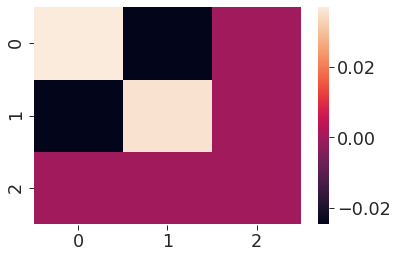

In [14]:
sns.heatmap(cov_estimator.fetch_model().cov_0t)

In [15]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= [tica.transform(traj) for traj in dataset.trajectories]
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

AttributeError: 'TrajectoryDataset' object has no attribute 'trajectories'

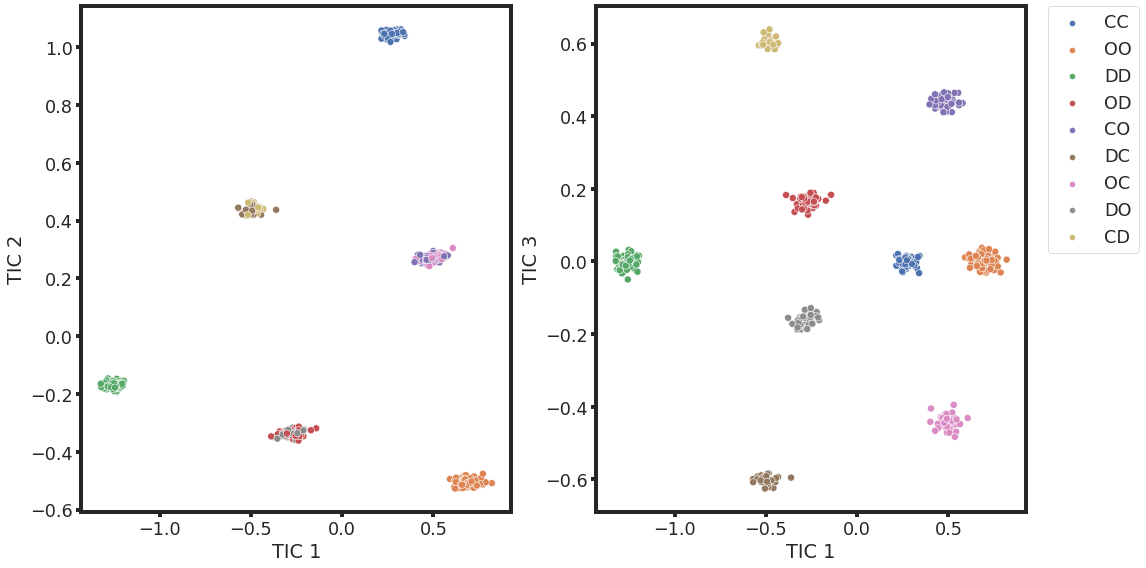

In [ ]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(
            x=feature_transformed[::100, 0],
            y=feature_transformed[::100, 1],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=feature_transformed[::100, 0],
            y=feature_transformed[::100, 3],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")

for ax in axes:
    set_axis_boarder(ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("assets/tica_dimer.pdf", dpi=300, transparent=True)

In [11]:
from msm_a7_nachrs.tica.sym_tica import SymVAMP_NOAUG

dataset = TrajectoryDataset(5, data[0])

symtica = SymVAMP_NOAUG(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset)
symtica_concatenated= np.concatenate(symtica_output)

(49995, 3)
(49995, 3)


/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 0: Not enough data (length=3) to satisfy lagtime=5.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 1: Not enough data (length=3) to satisfy lagtime=5.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 2: Not enough data (length=3) to satisfy lagtime=5.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 3: Not enough data (length=3) to satisfy lagtime=5.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)


TrajectoryTooShortError: All provided trajectories were too short for the provided lagtime of 5.

In [ ]:
symtica.fetch_model().cov_0t

(6, 6)

In [41]:
symtica_output_sum = np.sum(symtica_output, axis=1)

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

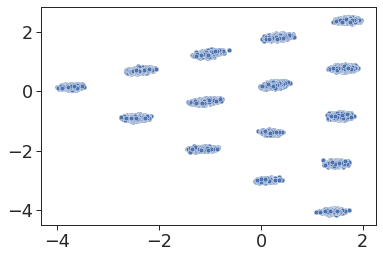

In [43]:
sns.scatterplot(*symtica_output_sum.T[:2])

In [26]:
from msm_a7_nachrs.tica.sym_tica import SymTICA

dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

symtica = SymTICA(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
symtica_concatenated= np.concatenate(symtica_output)

symmetry_fold 2


/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

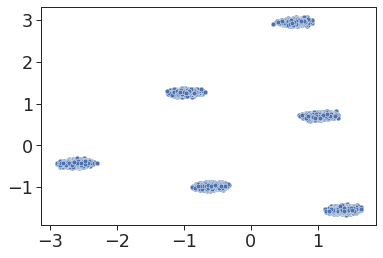

In [33]:
sns.scatterplot(*symtica_output.T)